# Loading data and pre-processing

In [2]:
A<- read.csv("000001.SS.csv",stringsAsFactors=FALSE,
             colClasses=c("Date","numeric","numeric"))
AZ<- read.csv("600036.SS-2.csv", stringsAsFactors=FALSE)
H<-read.csv("^HSI.csv",stringsAsFactors=FALSE)
HZ<-read.csv("3968.HK.csv",stringsAsFactors=FALSE)
H$Open<-as.numeric(H$Open)
H$Adj.Close<-as.numeric(H$Adj.Close)
H$Date<-as.Date(H$Date)
HZ$Open<-as.numeric(HZ$Open)
HZ$Adj.Close<-as.numeric(HZ$Adj.Close)
HZ$Date<-as.Date(HZ$Date)
AZ$Open<-as.numeric(AZ$Open)
AZ$Adj.Close<-as.numeric(AZ$Adj.Close)
AZ$Date<-as.Date(AZ$Date)
A<-A[which(complete.cases(A)),]
H<-H[which(complete.cases(H)),]
HZ<-HZ[which(complete.cases(HZ)),]
AZ<-AZ[which(complete.cases(AZ)),]
library(lubridate);library(TSA);
library(forecast);library(MSBVAR);library(zoo)

Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"Warning message in eval(expr, envir, enclos):
"强制改变过程中产生了NA"

In [3]:
Date.common<-intersect(intersect(intersect(A$Date,H$Date),AZ$Date),HZ$Date)
cat("Total length of the data:",length(Date.common))
A<-A[A$Date %in% Date.common,]
H<-H[H$Date %in% Date.common,]
AZ<-AZ[AZ$Date %in% Date.common,]
HZ<-HZ[HZ$Date %in% Date.common,]

Total length of the data: 2595

## Dividing Training Set and Test Set

In [4]:
data<-data.frame(Date=A$Date,
                 A=A$Open,
                 AZ=AZ$Open,
                 H=H$Open,
                 HZ=HZ$Open)
test.length<- 100 # Use data of the last 100 days as the training set.
data.train <- data[1:(nrow(data)-test.length),]
data.test <- data[(nrow(data)-test.length+1):nrow(data),]

## Have a Quick Glance at the Series

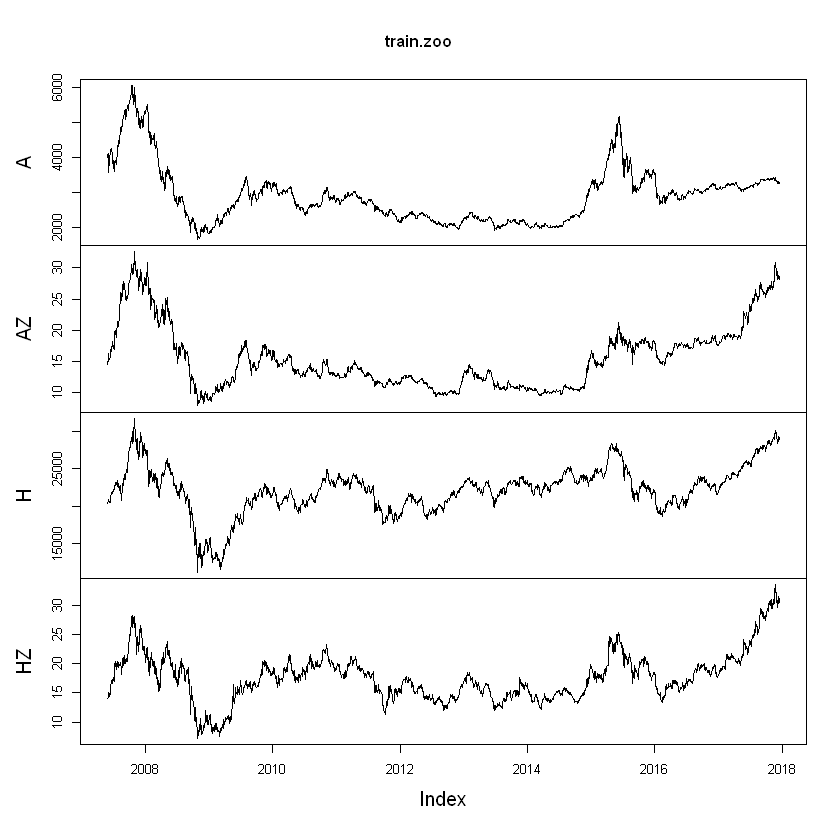

In [5]:
train.zoo<-zoo(data.train[-1],order.by = data.train$Date)
plot(train.zoo)

## Return: $100\times \Delta \log \mathbf{X}$

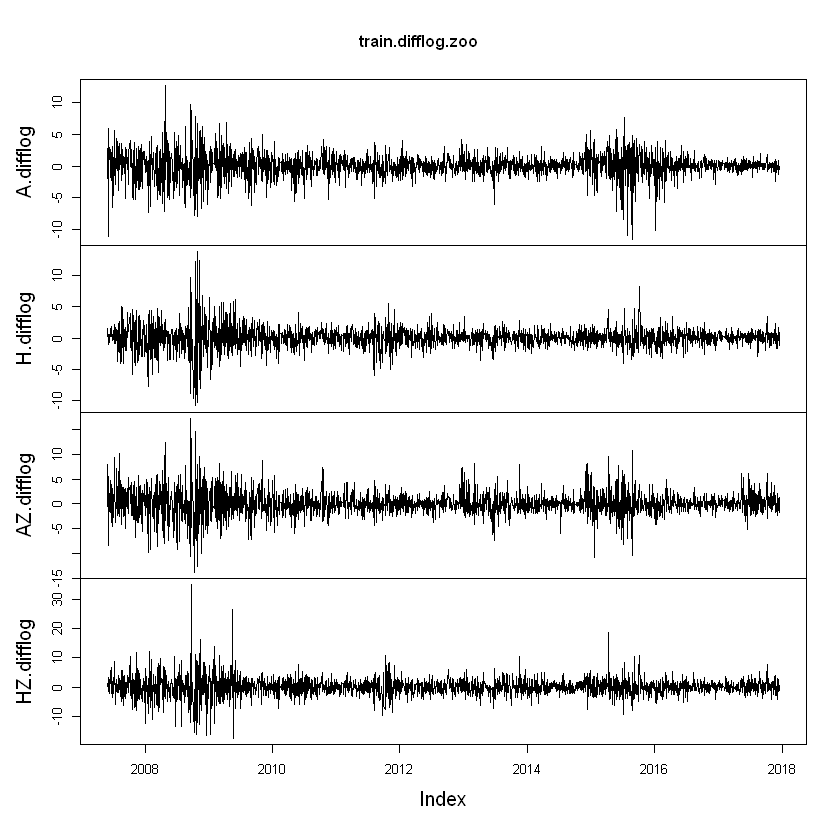

In [51]:
data.difflog<-data.frame(Date=data$Date[-1],
                         A.difflog=100*diff(log(data$A)),
                         H.difflog=100*diff(log(data$H)),
                         AZ.difflog=100*diff(log(data$AZ)),
                         HZ.difflog=100*diff(log(data$HZ)))
train.difflog<-data.difflog[1:(nrow(data.difflog)-test.length),]
test.difflog<-data.difflog[(nrow(data.difflog)-test.length+1):nrow(data.difflog),]
train.difflog.zoo<-zoo(train.difflog[-1],order.by = train.difflog$Date)
HZ.difflog.zoo<-zoo(train.difflog[5],order.by = train.difflog$Date)
plot(train.difflog.zoo)

All the returns appear to be stationary, which we can further check with ADF (Augmented Dickey-Fuller) test (case 2) as following:

In [7]:
library(urca)
sapply(train.difflog[-1],function(x) 
    ur.df(x,type="drift",lags=8,selectlags = "AIC"))

$A.difflog

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -23.9818 287.5636 


$H.difflog

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -17.6819 156.3248 


$AZ.difflog

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -36.7188 674.136 


$HZ.difflog

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
##############################################################

We see that all the null hypothesis (unit root) are **significantly rejected**. Thus these time series are indeed stationary.

# Fitting `HZ` alone with ARMA Model
## A function `Ljung_Box.test` to be used later

In [8]:
Ljung_Box.test <- function(ts,lag.max=30) {
    B <- NULL
    for (i in 1:lag.max) {
        B <- c(B, Box.test(ts, lag = i, type = "Ljung-Box")$p.value)
    }
    plot(B, main = "Ljung-Box tests", ylab = "p-value", 
         xlab = "lag", pch = 16, ylim = c(0, 1))
    abline(h = 0.05, lty = 2)
}

## ACF, PACF and EACF

AR/MA
   0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
0  x o o o o o o o o o o  o  o  o  o  o 
1  x o o o o o o o o o o  o  o  o  o  o 
2  x x o o o o o o o o o  o  o  o  o  o 
3  x x x o o o o o o o o  o  o  o  o  o 
4  x x x x o o o o o o o  o  o  o  o  o 
5  x x x x x o o o o o o  o  o  o  o  o 
6  x x x x x x o o o o o  o  o  o  o  o 
7  x o x o o x x o o o o  o  o  o  o  o 
8  x x x x o x o o o o o  o  o  o  o  o 
9  x x x o o o o o x o o  o  o  o  o  o 
10 x x x x o o x o x x o  o  o  o  o  o 


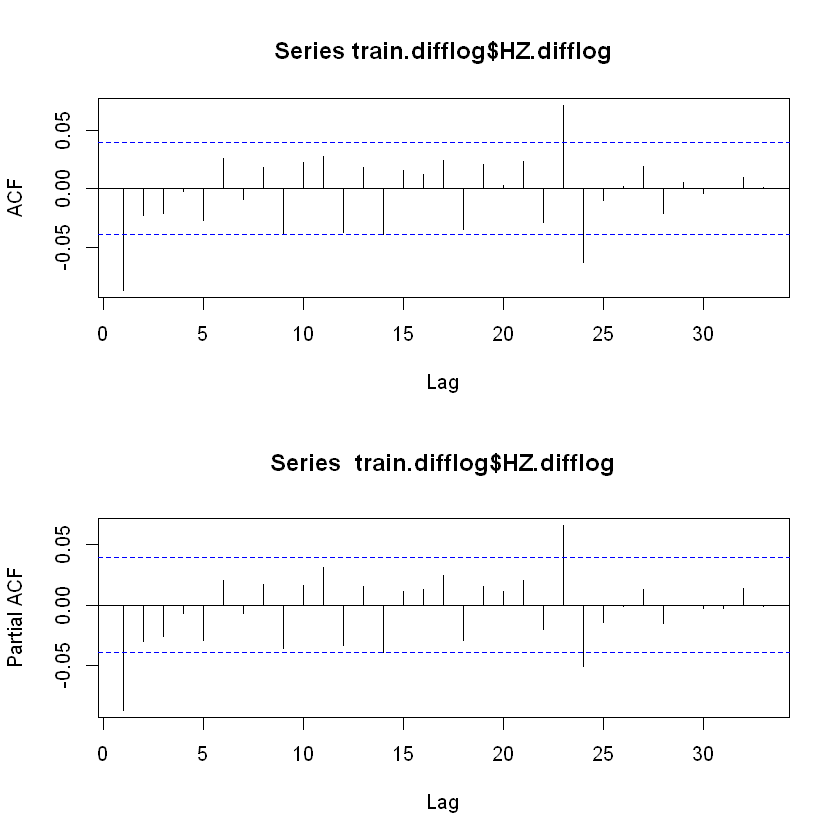

In [9]:
par(mfcol=c(2,1))
acf(train.difflog$HZ.difflog)
pacf(train.difflog$HZ.difflog)
eacf(train.difflog$HZ.difflog,
     ma.max = 15,ar.max = 10) # suggests a MA(1) model

## ARMA
**EACF suggests a MA(1) model.** We can also use `forecast::auto.arima` function to choose an arima model (according to the **lowest AIC**).

Series: train.difflog$HZ.difflog 
ARIMA(0,0,1) with zero mean     

Coefficients:
          ma1
      -0.0916
s.e.   0.0205

sigma^2 estimated as 9.216:  log likelihood=-6307.89
AIC=12619.78   AICc=12619.79   BIC=12631.43

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE        ACF1
Training set 0.03427941 3.035228 2.075355 NaN  Inf 0.6919315 0.002251774


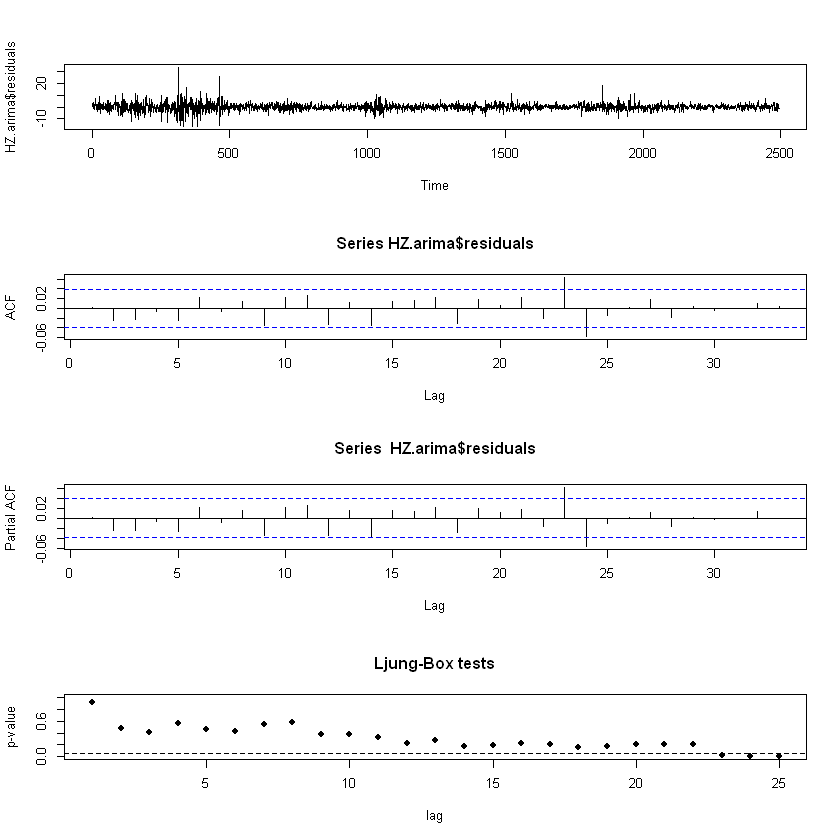

In [10]:
HZ.arima<-auto.arima(train.difflog$HZ.difflog,
                     seasonal = FALSE, ic="aic") # Auto-selected model is also MA(1)
summary(HZ.arima)
par(mfcol=c(4,1))
plot(HZ.arima$residuals)
acf(HZ.arima$residuals)
pacf(HZ.arima$residuals)
Ljung_Box.test(HZ.arima$residuals,lag.max = 25)

The residuals are already close to white noise.

## Prediction with ARMA
### 5-step ahead forecasting

     Point Forecast     Lo 95    Hi 95
2495      0.1010244 -5.849105 6.051154
2496      0.0000000 -5.975020 5.975020
2497      0.0000000 -5.975020 5.975020
2498      0.0000000 -5.975020 5.975020
2499      0.0000000 -5.975020 5.975020

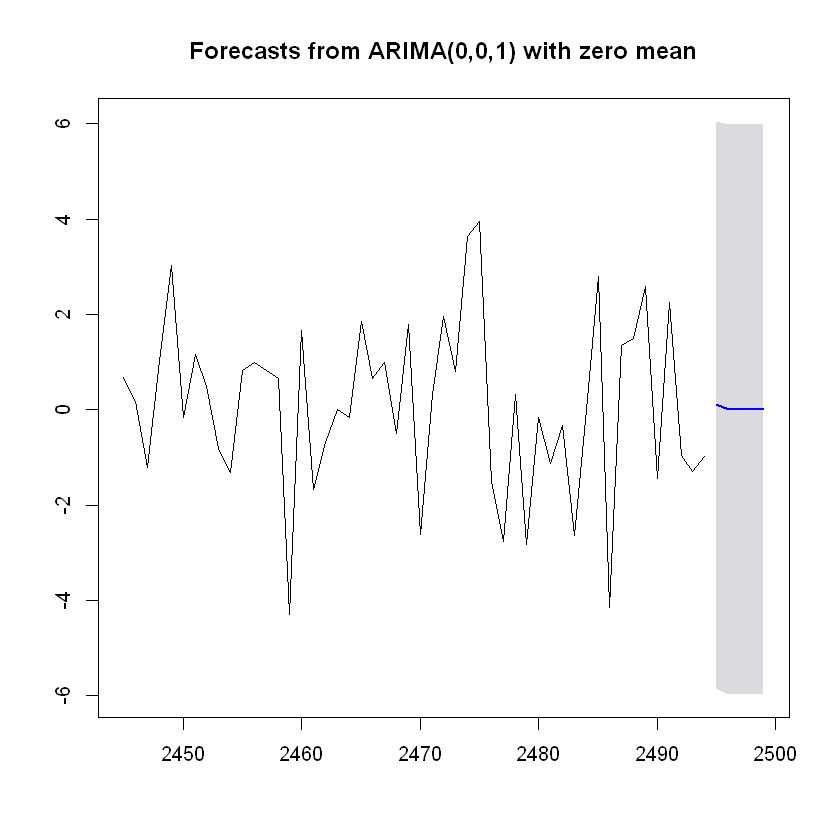

In [11]:
HZ.arima.forecast<-forecast::forecast(HZ.arima,h = 5,level=95)
HZ.arima.forecast
forecast::plot.forecast(HZ.arima.forecast,include=50)

### 1-step Prediction on Test Set

Total Sum of Square: 591.3824 
Test RMSE of MA(1): 2.432285 
Test R-squared of MA(1): -0.0003701391 
Standard Deviation of y: 2.444087

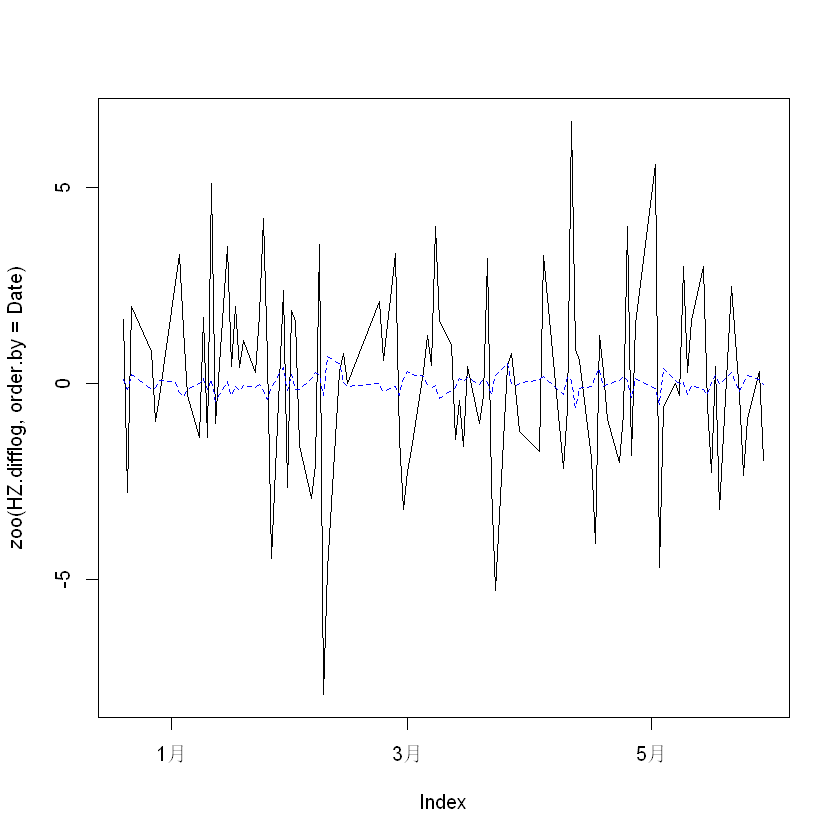

In [12]:
refit<-Arima(data.difflog$HZ.difflog,model=HZ.arima)
# Total Sum of Squares
TSS<-sum((test.difflog$HZ.difflog-mean(test.difflog$HZ.difflog))^2)
Resid.SS.ARMA<-sum((tail(refit$residuals,100))^2)

with(test.difflog,
     plot(zoo(HZ.difflog,
              order.by=Date),col="black"))
points(zoo(tail(fitted.values(refit),100),
           order.by=test.difflog$Date),col="blue",type="l",lty=2)

cat("Total Sum of Square:",TSS,'\n')
# Rooted Mean Square Error
cat("Test RMSE of MA(1):",sqrt(Resid.SS.ARMA/test.length),'\n')
cat("Test R-squared of MA(1):",1-Resid.SS.ARMA/TSS,'\n')
cat("Standard Deviation of y:", sd(test.difflog$HZ.difflog))

# Variance Model
Although ACF and PACF of the MA(1) above are acceptable (look quite like white noise), the series shows clusters of volatility, which suggests an ARCH/GARCH model.
Let's first look at the **squared residuals plot**.

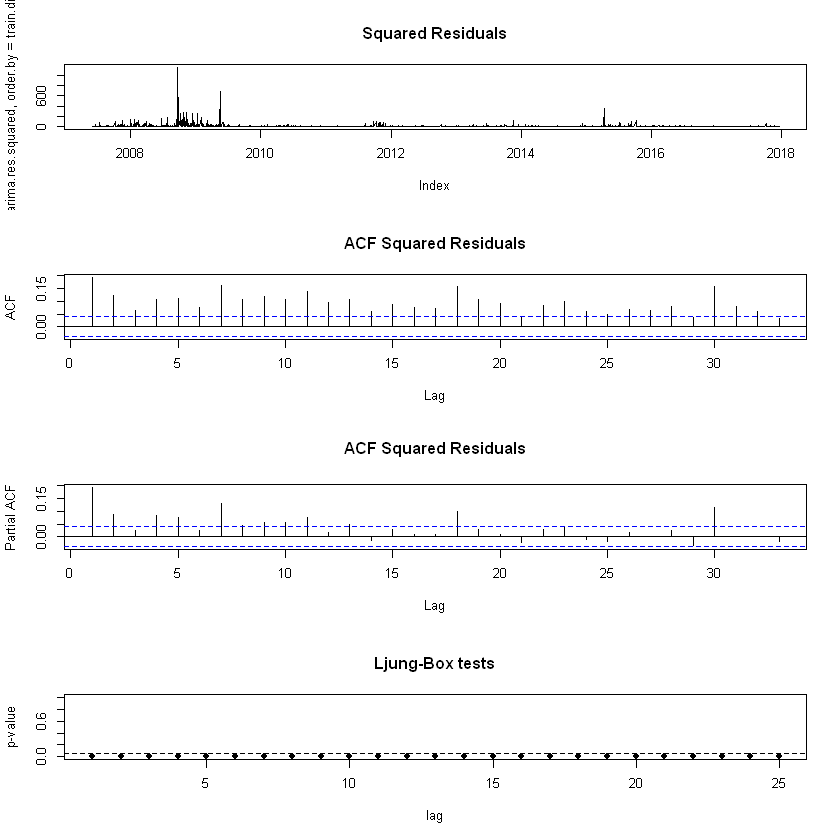

In [50]:
HZ.arima.res.squared<-(HZ.arima$residuals)^2
par(mfcol=c(4,1))
plot(zoo(HZ.arima.res.squared,
         order.by = train.difflog$Date),main='Squared Residuals')
acf(HZ.arima.res.squared,main='ACF Squared Residuals')
pacf(HZ.arima.res.squared,main='ACF Squared Residuals')
Ljung_Box.test(HZ.arima.res.squared, lag.max = 25)

We see unusually high volatility in 2008 - 2009. In addition, the ACF, PACF, `Ljung-Box` Test all indicate a **heterogeneous variance**.

## ARCH/GARCH
First, we use the residuals of the MA(1) model to test if ARCH effects are siginificant.
### Lagrange Multiplier Test

In [15]:
library(FinTS)
ArchTest(HZ.arima$residuals, lag=3)
ArchTest(HZ.arima$residuals, lag=6)
ArchTest(HZ.arima$residuals, lag=12)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  HZ.arima$residuals
Chi-squared = 112.94, df = 3, p-value < 2.2e-16



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  HZ.arima$residuals
Chi-squared = 144.91, df = 6, p-value < 2.2e-16



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  HZ.arima$residuals
Chi-squared = 217.77, df = 12, p-value < 2.2e-16


Thus we're convinced there is significant ARCH effects (i.e. **heterogeneous variance**).

### Determination of the Variance Model
Then we determine the order p via PACF and Ljung Box test. Using the ACF, PACF and Ljung Box Test of the **squared residuals** above, it seems that we should choose a very high order of ARCH model (p>8), which may instead suggest a conventional **GARCH (1,1)** variance model.

## Joint Estimation of the Mean and Volatility Equations

We finally picked out the **ARMA(0,1) - GARCH(1,1)** model corresponding to the **lowest BIC**.


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.046470    0.041915   1.1087 0.267575
ma1    -0.061749    0.021005  -2.9398 0.003285
omega   0.045968    0.018770   2.4491 0.014323
alpha1  0.057524    0.009776   5.8839 0.000000
beta1   0.938863    0.010292  91.2191 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.046470    0.042835   1.0849 0.277984
ma1    -0.061749    0.023249  -2.6559 0.007909
omega   0.045968    0.036475   1.2603 0.207570
alpha1  0.057524    0.024680   2.3308 0.019766
beta1   0.938863    0.026140  35.9162 0.000000

LogLikelihood : -5878.477 

Information Criteria
------------------------------------
               

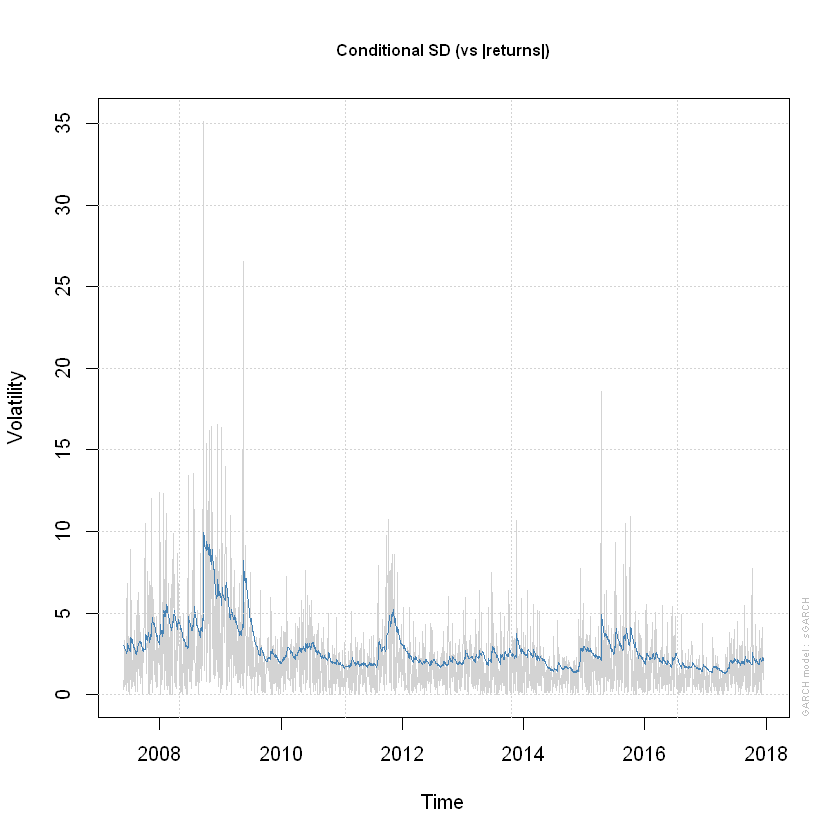

In [17]:
library('rmgarch')
spec <- ugarchspec(variance.model = list(model = "sGARCH",
                                         garchOrder = c(1,1), 
                                         submodel = NULL),
                    mean.model = list( armaOrder =c(0,1),
                                      include.mean=TRUE) , 
                   distribution.model = "norm" )
HZ.arima.GARCH<-ugarchfit(spec=spec, 
                          data=zoo(data.difflog$HZ.difflog,order.by = data.difflog$Date),
                          out.sample=test.length); HZ.arima.GARCH
#for (x in 1:12) plot(HZ.arima.GARCH,which=x)
plot(HZ.arima.GARCH,which=3)

## Residual Diagnosis

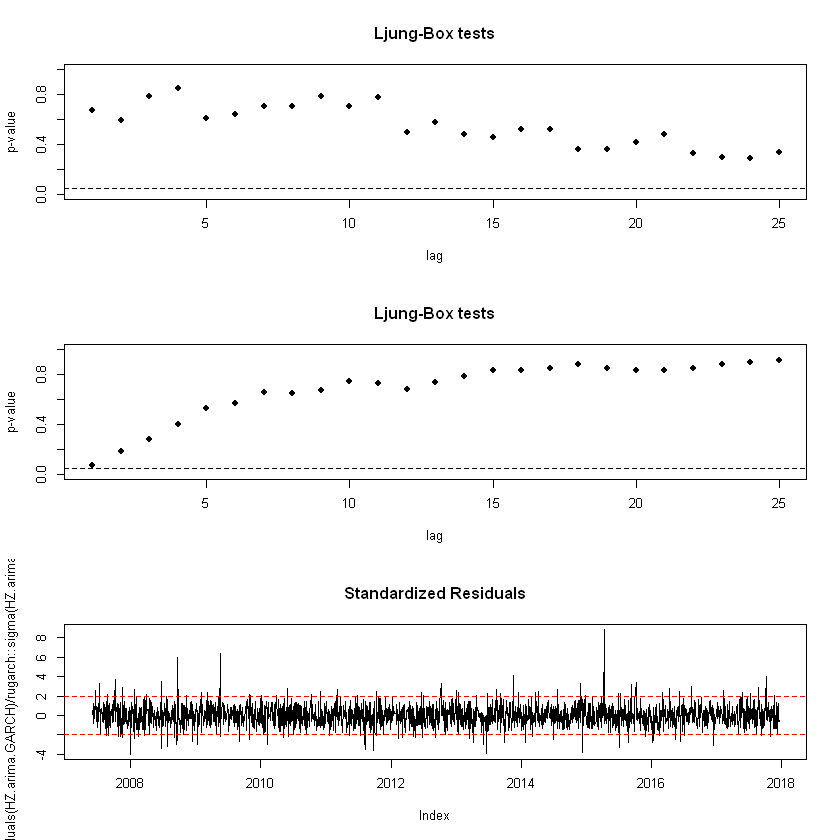

In [18]:
par(mfcol=c(3,1))
Ljung_Box.test(rugarch::residuals(HZ.arima.GARCH)/
               rugarch::sigma(HZ.arima.GARCH),lag.max = 25)
Ljung_Box.test((rugarch::residuals(HZ.arima.GARCH)/
                rugarch::sigma(HZ.arima.GARCH))^2,lag.max = 25)
plot(zoo(residuals(HZ.arima.GARCH)/rugarch::sigma(HZ.arima.GARCH),
         order.by =train.difflog$Date),main="Standardized Residuals")
abline(h=c(1.96,-1.96),col='red',lty=2)

## 5-step Ahead Forecast

In [52]:
garch.forecast<-ugarchforecast(HZ.arima.GARCH,n.ahead=5) # 5-step forecast
sigma(garch.forecast);fitted(garch.forecast)

,2017-12-19
T+1,2.081251
T+2,2.088522
T+3,2.095742
T+4,2.102911
T+5,2.110030


,2017-12-19
T+1,0.11508126
T+2,0.04646987
T+3,0.04646987
T+4,0.04646987
T+5,0.04646987


## 1-step Prediction on Test Set

In [21]:
HZ.garch.spec = getspec(HZ.arima.GARCH)
setfixed(HZ.garch.spec) <- as.list(coef(HZ.arima.GARCH))
HZ.garch.forecast = ugarchforecast(HZ.garch.spec, n.ahead = 1,
                                   n.roll = test.length-1, 
                                   data =zoo(data.difflog$HZ.difflog,order.by = data.difflog$Date),
                                   out.sample = test.length);
garch.pred<-fitted(HZ.garch.forecast);garch.pred

,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-27,2017-12-28,2017-12-29,2018-01-02,2018-01-03,2018-01-04,...,2018-05-14,2018-05-15,2018-05-16,2018-05-17,2018-05-18,2018-05-21,2018-05-23,2018-05-24,2018-05-25,2018-05-28
T+1,0.1150813,-0.04683044,0.2152533,-0.06191457,-0.007352393,0.1060634,0.07316572,-0.1083723,-0.163329,-0.04865713,...,-0.1410225,0.07245241,0.1916871,0.03167187,0.2464697,-0.09189951,0.05866711,0.1949637,0.1137236,0.03503254


Test RMSE: 2.429412 
Test R-squared of MA(1)-GARCH(1,1): 0.001991952

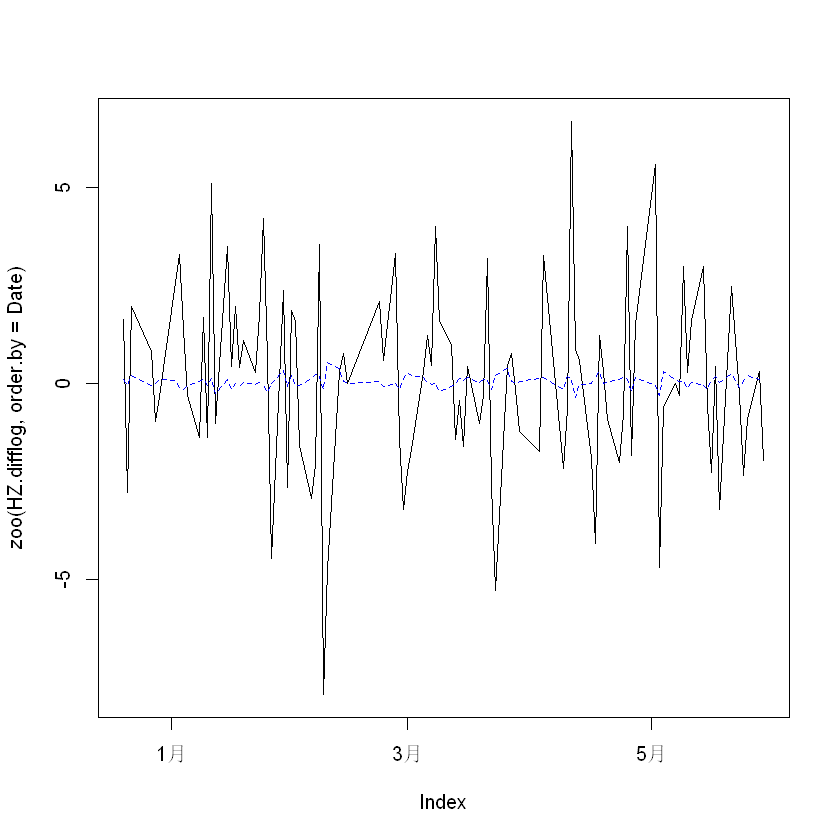

In [22]:
with(test.difflog,
     plot(zoo(HZ.difflog,
              order.by=Date),col="black"))
points(zoo(as.vector(garch.pred),
           order.by=test.difflog$Date),col="blue",type="l",lty=2)
Resid.SS.GARCH<-sum((test.difflog$HZ.difflog-garch.pred)^2)
cat("Test RMSE:",sqrt(Resid.SS.GARCH/test.length),'\n')
cat("Test R-squared of MA(1)-GARCH(1,1):",1-Resid.SS.GARCH/TSS)

# VAR Model

Next we are going to fit the multivariate series ($p=4$) with a VAR model with a selected and parsimony order. We expect the VAR Model performs better at prediction as it makes use of more information.

## Order Selection and Fitting

In [24]:
library(vars)
VARselect(train.difflog[-1],type="none")
# AIC and BIC differ. we will choose a relatively parsimony, p=2 selected by HQ
difflog.VAR <- vars::VAR(train.difflog[-1], p = 2, type = "none", ic = "SC")
summary(difflog.VAR)

,1,2,3,4,5,6,7,8,9,10
AIC(n),4.544197,4.520487,4.511527,4.508574,4.509658,4.515052,4.508995,4.506617,4.509183,4.490117
HQ(n),4.557806,4.547705,4.552354,4.563009,4.577702,4.596705,4.604256,4.615487,4.631662,4.626204
SC(n),4.581670,4.595433,4.623945,4.658465,4.697021,4.739888,4.771303,4.806398,4.846437,4.864843
FPE(n),94.084851,91.880377,91.060826,90.792333,90.890885,91.382546,90.830798,90.615252,90.848326,89.132844



VAR Estimation Results:
Endogenous variables: A.difflog, H.difflog, AZ.difflog, HZ.difflog 
Deterministic variables: none 
Sample size: 2492 
Log Likelihood: -19780.776 
Roots of the characteristic polynomial:
0.4131 0.4131 0.255 0.255 0.2239 0.2239 0.1799 0.1799
Call:
vars::VAR(y = train.difflog[-1], p = 2, type = "none", ic = "SC")


Estimation results for equation A.difflog: 
A.difflog = A.difflog.l1 + H.difflog.l1 + AZ.difflog.l1 + HZ.difflog.l1 + A.difflog.l2 + H.difflog.l2 + AZ.difflog.l2 + HZ.difflog.l2 

               Estimate Std. Error t value Pr(>|t|)   
A.difflog.l1  -0.085981   0.029796  -2.886  0.00394 **
H.difflog.l1   0.083165   0.029460   2.823  0.00480 **
AZ.difflog.l1 -0.006001   0.023755  -0.253  0.80057   
HZ.difflog.l1  0.014069   0.016298   0.863  0.38810   
A.difflog.l2  -0.048675   0.029960  -1.625  0.10436   
H.difflog.l2  -0.058908   0.030361  -1.940  0.05247 . 
AZ.difflog.l2  0.005258   0.023873   0.220  0.82568   
HZ.difflog.l2  0.043873   0.015628   2.80

AIC and BIC differ. We will continue with a relatively parsimony choice, $p=2$ selected by HQ criteria
## Model Restriction
We will **refit the model** by leaving out insignificant terms


VAR Estimation Results:
Endogenous variables: A.difflog, H.difflog, AZ.difflog, HZ.difflog 
Deterministic variables: none 
Sample size: 2492 
Log Likelihood: -19797.195 
Roots of the characteristic polynomial:
0.3797 0.3797 0.2004 0.2004 0.1866 0.1866 0.1456 0.1456
Call:
vars::VAR(y = train.difflog[-1], p = 2, type = "none", ic = "SC")


Estimation results for equation A.difflog: 
A.difflog = A.difflog.l1 + H.difflog.l1 + A.difflog.l2 + HZ.difflog.l2 

              Estimate Std. Error t value Pr(>|t|)    
A.difflog.l1  -0.09160    0.02267  -4.041 5.49e-05 ***
H.difflog.l1   0.09618    0.02543   3.782 0.000159 ***
A.difflog.l2  -0.05689    0.02137  -2.662 0.007812 ** 
HZ.difflog.l2  0.02888    0.01305   2.212 0.027048 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 1.855 on 2488 degrees of freedom
Multiple R-Squared: 0.01175,	Adjusted R-squared: 0.01016 
F-statistic: 7.396 on 4 and 2488 DF,  p-value: 6.423e-06 


Estimation results for

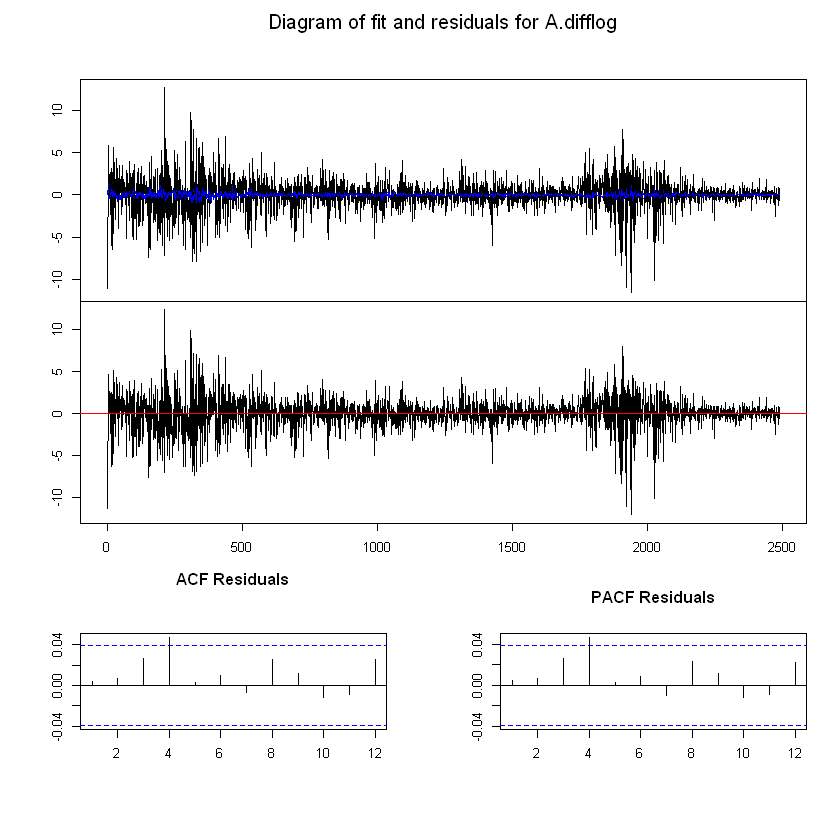

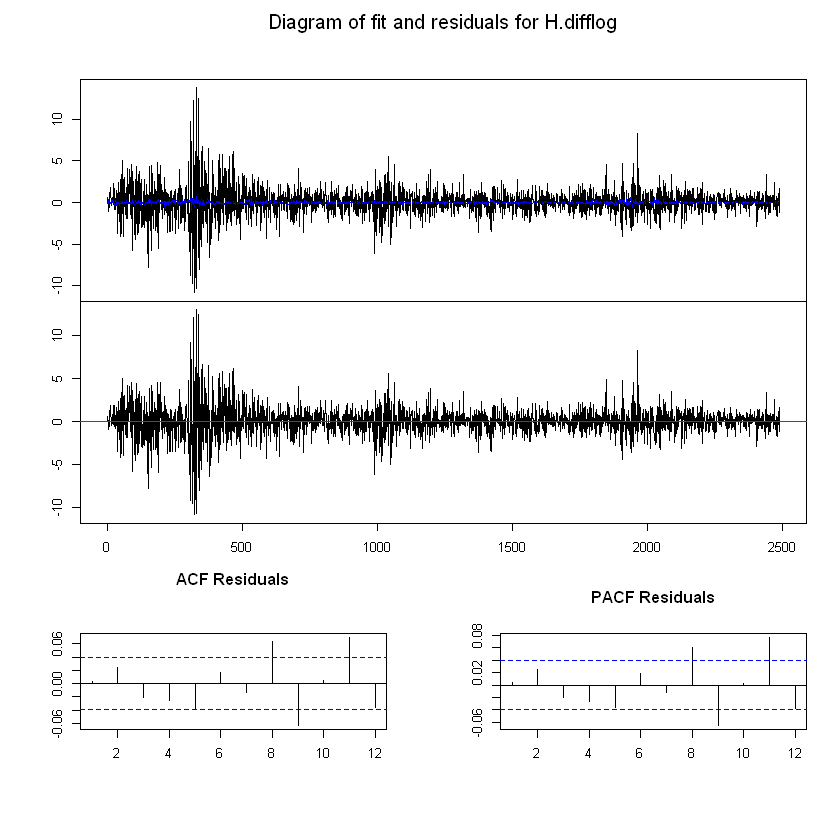

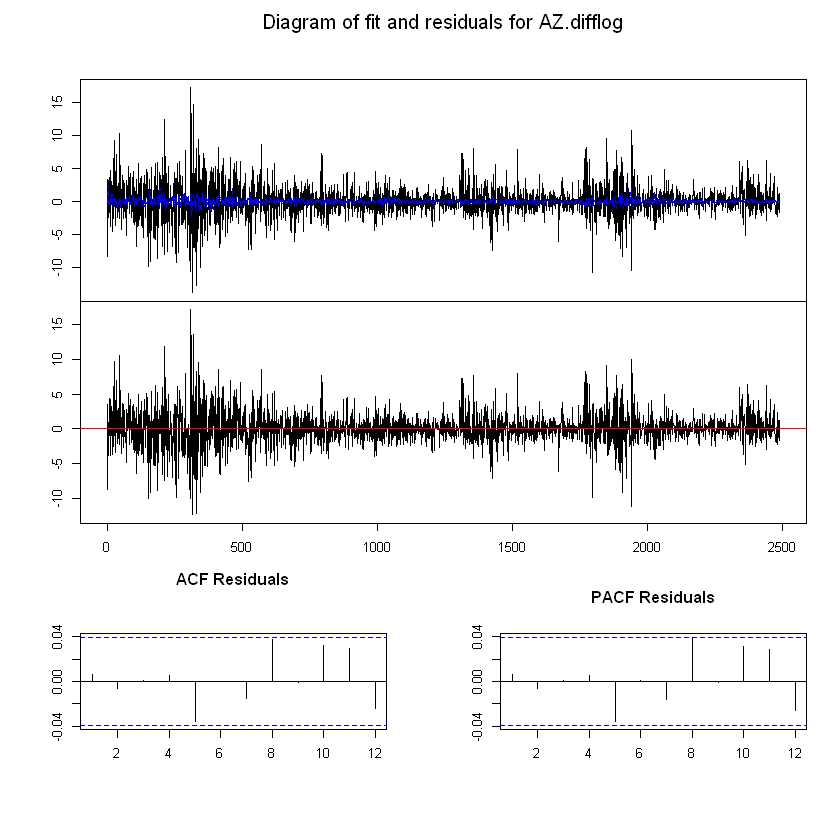

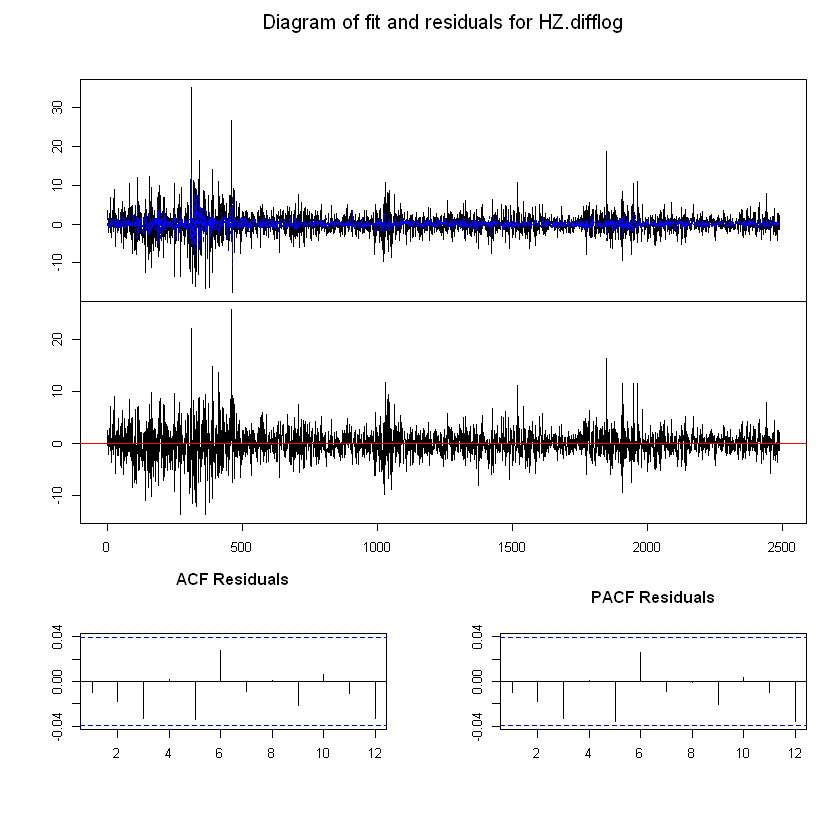

In [25]:
difflog.VARR<- restrict (difflog.VAR)
summary(difflog.VARR)
plot(difflog.VARR)

Perhaps not surprisingly, `HZ` has a very high R-squared (12.88%) comparing with others (<3%). That is, a fairly large part of `HZ`'s variation can be explained by the other 3 time serieses.

## Granger Test

In [26]:
granger.test(train.difflog[-1],p=1)
granger.test(train.difflog[-1],p=2)

,F-statistic,p-value
H.difflog -> A.difflog,1.510740e+01,1.042169e-04
AZ.difflog -> A.difflog,8.476567e-01,3.573053e-01
HZ.difflog -> A.difflog,1.893140e+00,1.689719e-01
A.difflog -> H.difflog,8.302474e+00,3.992992e-03
AZ.difflog -> H.difflog,1.207388e+00,2.719562e-01
HZ.difflog -> H.difflog,1.487695e-04,9.902693e-01
A.difflog -> AZ.difflog,2.218754e+01,2.608617e-06
H.difflog -> AZ.difflog,1.023359e+01,1.396382e-03
HZ.difflog -> AZ.difflog,2.311347e+00,1.285597e-01
A.difflog -> HZ.difflog,4.087138e+01,1.934775e-10


,F-statistic,p-value
H.difflog -> A.difflog,7.2772819,7.058765e-04
AZ.difflog -> A.difflog,0.4697697,6.252017e-01
HZ.difflog -> A.difflog,4.3429416,1.309696e-02
A.difflog -> H.difflog,5.9446107,2.657295e-03
AZ.difflog -> H.difflog,3.6309246,2.663221e-02
HZ.difflog -> H.difflog,0.1130155,8.931414e-01
A.difflog -> AZ.difflog,11.5848738,9.818499e-06
H.difflog -> AZ.difflog,6.5104217,1.513337e-03
HZ.difflog -> AZ.difflog,8.3152313,2.516295e-04
A.difflog -> HZ.difflog,22.9792111,1.292246e-10


While other variables "granger cause" `HZ`(`AZ`), `HZ` (`AZ`) does not "granger cause" others, which seems quite reasonable.

## Residuals Diagnosis

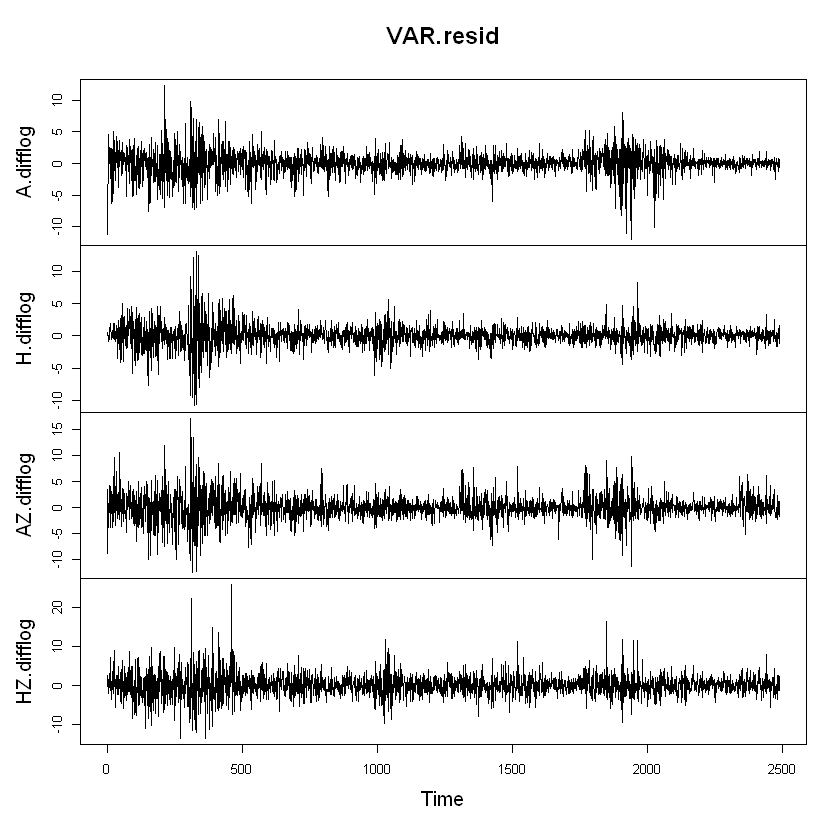

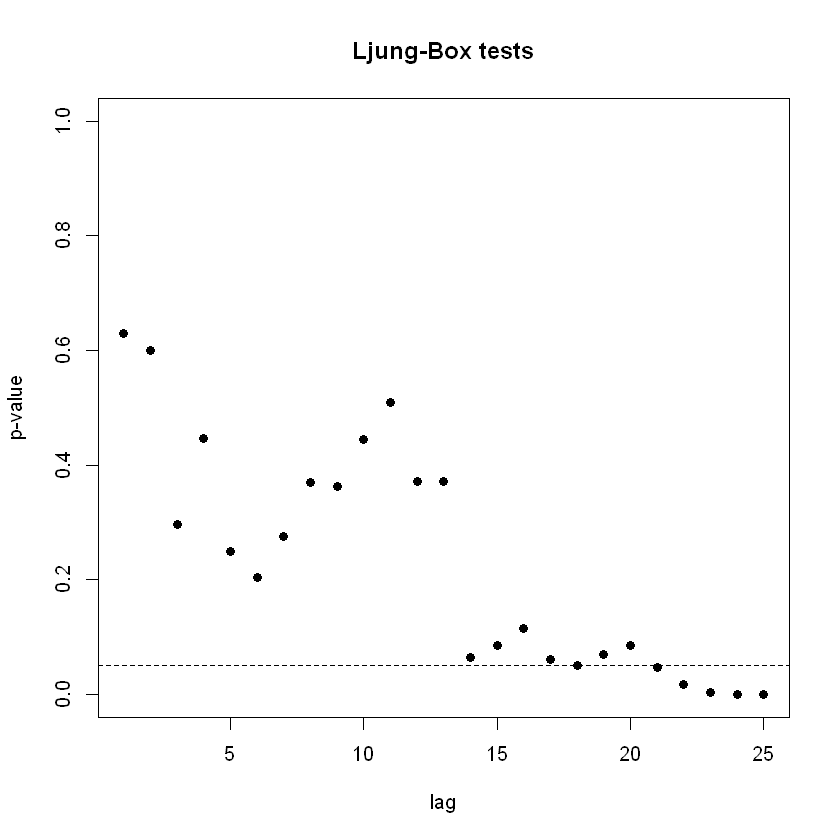

In [28]:
VAR.resid<-residuals(difflog.VARR)
plot.ts(VAR.resid)
Ljung_Box.test(VAR.resid[,'HZ.difflog'],lag.max = 25)

## VAR Predict
### 5-step prediction

In [29]:
VAR.5step.pred<-predict(difflog.VARR,n.ahead= 5, ci=0.95);VAR.5step.pred

$A.difflog
             fcst     lower    upper       CI
[1,]  0.091659210 -3.544125 3.727443 3.635784
[2,] -0.028318950 -3.679185 3.622547 3.650866
[3,]  0.033754239 -3.622778 3.690287 3.656533
[4,] -0.006916649 -3.664039 3.650205 3.657122
[5,] -0.004414584 -3.661559 3.652730 3.657144

$H.difflog
             fcst     lower    upper       CI
[1,]  0.050248645 -3.201893 3.302390 3.252142
[2,] -0.042021672 -3.300454 3.216411 3.258433
[3,] -0.001937080 -3.262812 3.258938 3.260875
[4,] -0.000201450 -3.261183 3.260780 3.260982
[5,] -0.001599401 -3.262587 3.259388 3.260987

$AZ.difflog
             fcst     lower    upper       CI
[1,]  0.124485853 -4.485654 4.734626 4.610140
[2,] -0.059433613 -4.709572 4.590705 4.650139
[3,]  0.070310888 -4.590890 4.731512 4.661201
[4,] -0.014397094 -4.677408 4.648614 4.663011
[5,] -0.007565981 -4.670644 4.655512 4.663078

$HZ.difflog
            fcst     lower    upper       CI
[1,]  1.39961354 -4.183788 6.983015 5.583402
[2,] -0.18179160 -6.143877 5.7802

### 1-step Prediction on Test Set

In [30]:
VAR.coef<-coef(difflog.VARR)$HZ.difflog;VAR.coef
Y.lag1<-data.difflog[(nrow(data.difflog)-test.length):(nrow(data.difflog)-1),-1]
#Y.lag2<-data.difflog[(nrow(data.difflog)-1-test.length):(nrow(data.difflog)-2),-1]
Y.lag2<-data.difflog[(nrow(data.difflog)-1-test.length):(nrow(data.difflog)-2),c(3,5)]
#Y.hat.VAR<-as.matrix.data.frame(Y.lag1) %*% VAR.coef[
#    1:4,"Estimate"]+as.matrix.data.frame(Y.lag2) %*% VAR.coef[5:8,"Estimate"]
Y.hat.VAR<-as.matrix.data.frame(Y.lag1) %*% VAR.coef[
    1:4,"Estimate"]+as.matrix.data.frame(Y.lag2) %*% VAR.coef[
    5:6,"Estimate"]#+as.matrix.data.frame(Y.lag3) %*% VAR.coef[7:8,"Estimate"]
Resid.SS.VAR<-sum((Y.hat.VAR-test.difflog$HZ.difflog)^2)
cat("Test RMSE of VAR(2):",sqrt(Resid.SS.VAR/test.length),'\n')
cat("Test R-squared of VAR(2):",1-Resid.SS.VAR/TSS)

,Estimate,Std. Error,t value,Pr(>|t|)
A.difflog.l1,-0.1801069,0.04573654,-3.937922,8.445031e-05
H.difflog.l1,0.6637372,0.04512242,14.709697,4.994506e-47
AZ.difflog.l1,0.2601738,0.03625891,7.175444,9.470830e-13
HZ.difflog.l1,-0.3537521,0.02463916,-14.357310,5.729355e-45
H.difflog.l2,0.1767725,0.04412496,4.006179,6.352102e-05
HZ.difflog.l2,-0.1018745,0.02328416,-4.375271,1.262854e-05


Test RMSE of VAR(2): 2.406403 
Test R-squared of VAR(2): 0.02080655

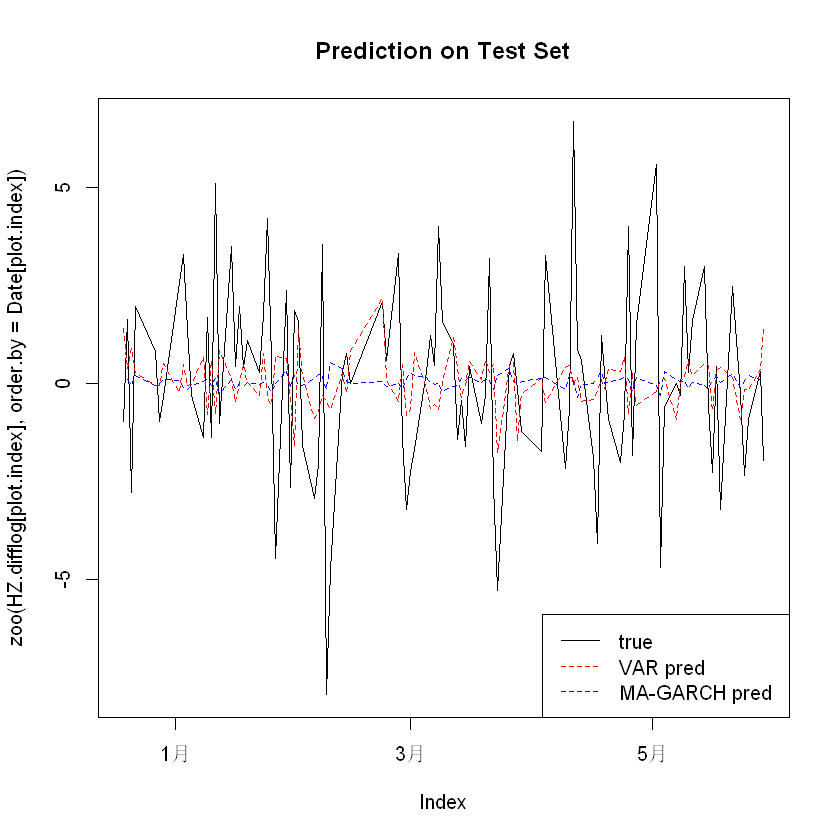

In [31]:
plot.index<-(length(refit$residuals)-
             test.length):(length(refit$residuals))
with(data.difflog,
     plot(zoo(HZ.difflog[plot.index],
             order.by=Date[plot.index]),
          col="black",main="Prediction on Test Set"))
points(zoo(Y.hat.VAR,
           order.by=data.difflog$Date[plot.index]),col="red",type="l",lty=2)
points(zoo(as.vector(garch.pred),
           order.by=test.difflog$Date),col="blue",type="l",lty=2)
legend("bottomright",c("true","VAR pred", "MA-GARCH pred"),
       col=c("black","red","blue"),lty=c(1,2,2))

## Variance Decomposition

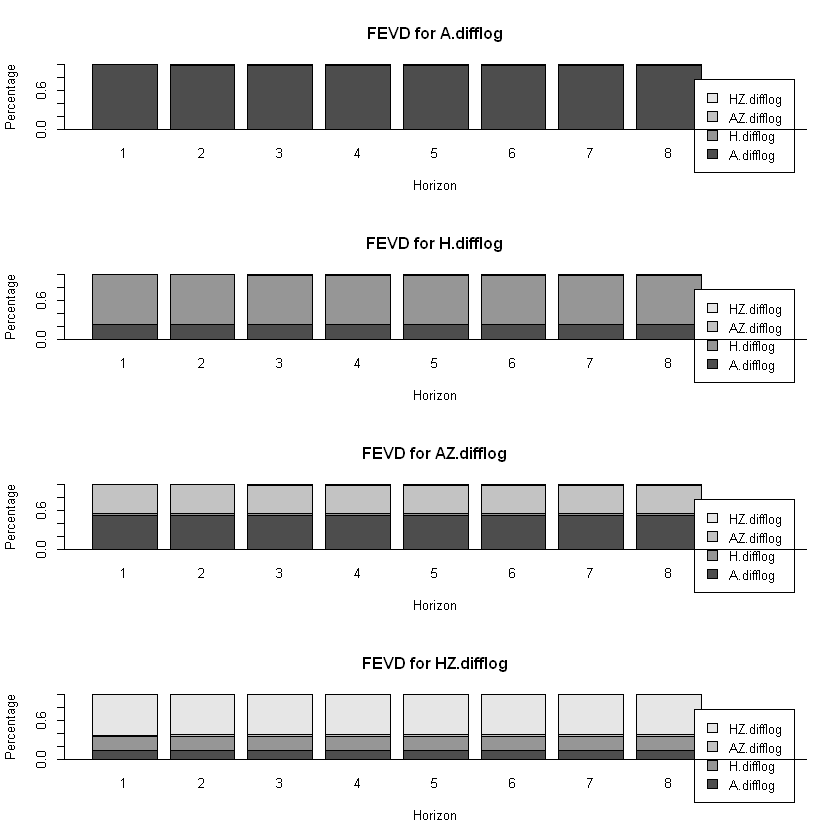

In [56]:
#vars::fevd(difflog.VAR,n.ahead=8)
plot(vars::fevd(difflog.VAR,n.ahead=8))

## Impulse Response Function

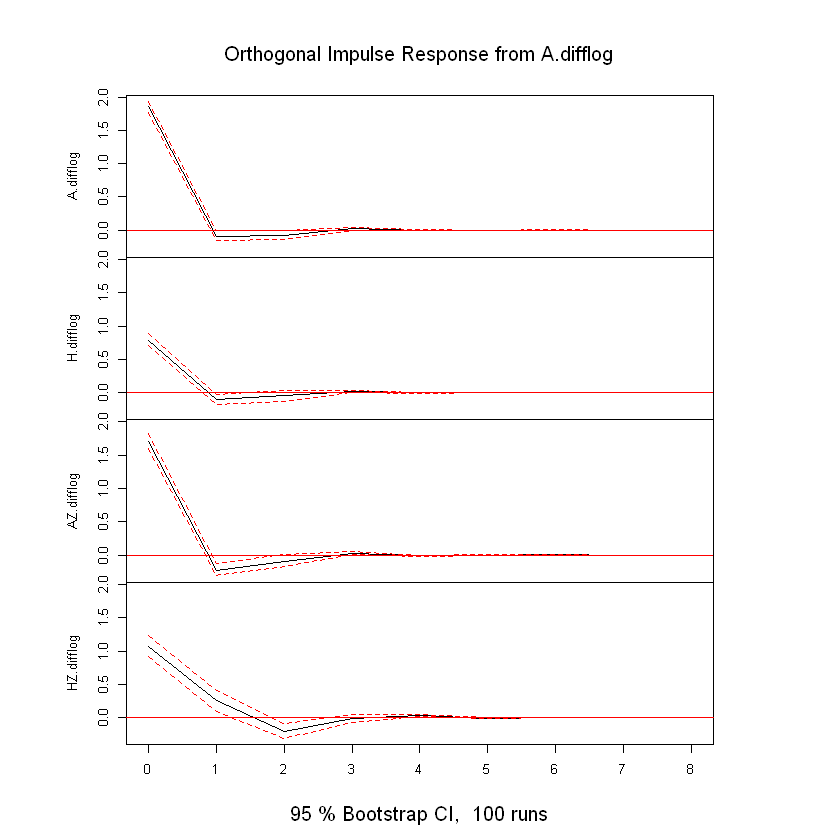

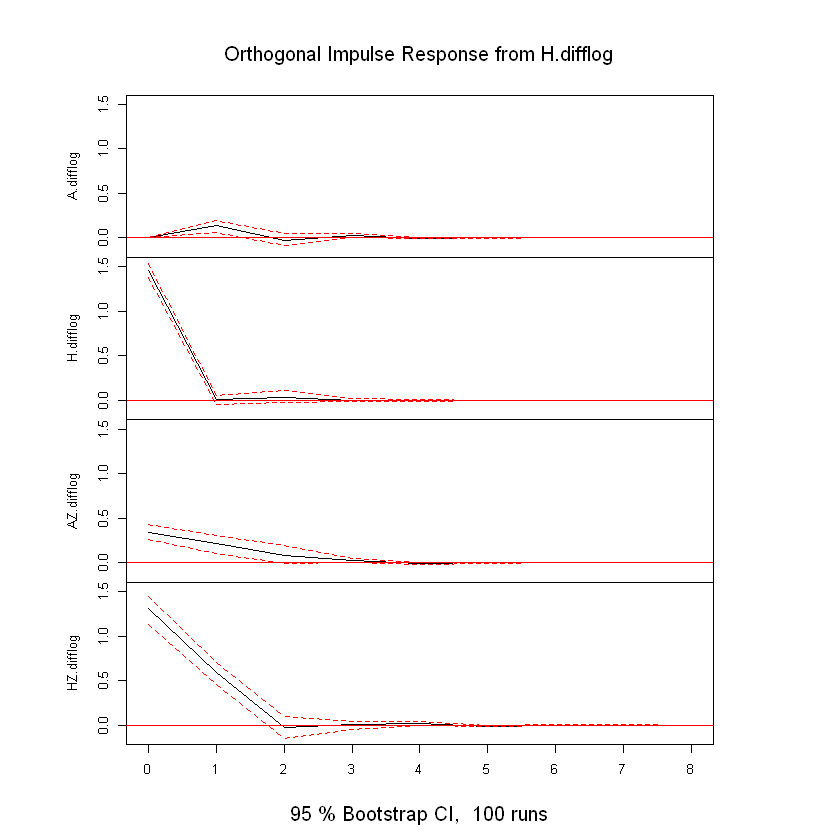

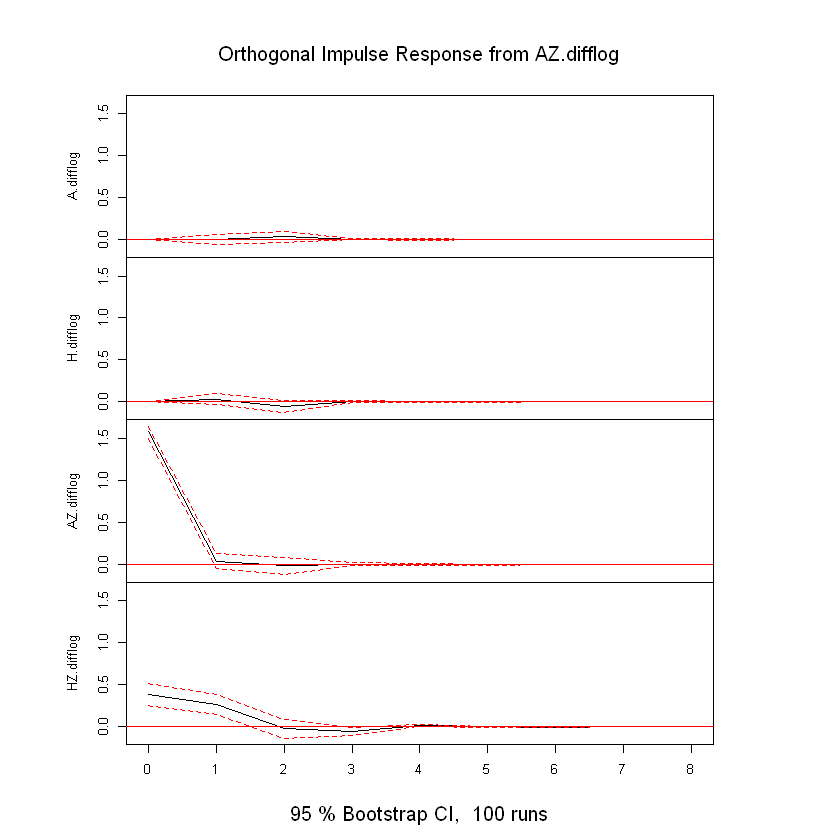

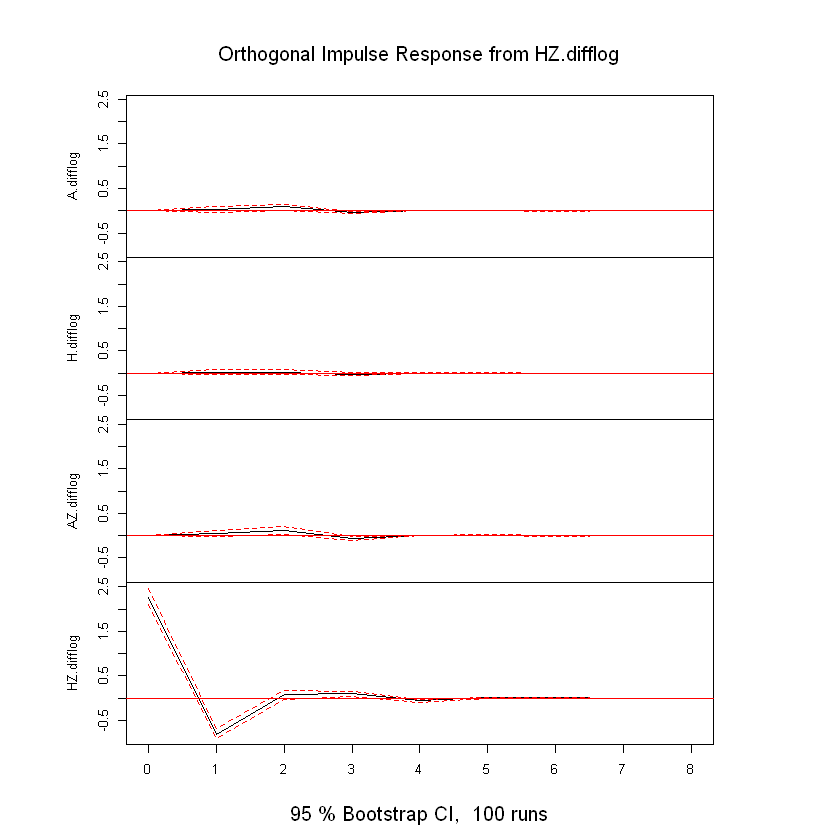

In [57]:
#vars::irf(difflog.VAR,n.ahead=8)
plot(vars::irf(difflog.VAR,n.ahead=8))

## Cointegration Test
### Using Price instead of Return

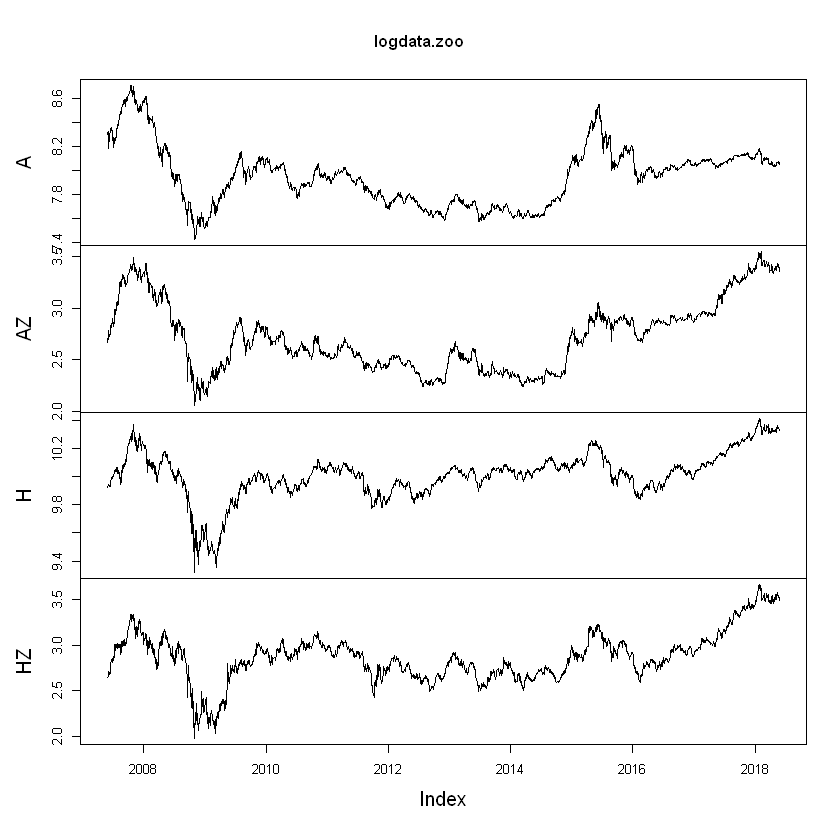

In [47]:
logdata<-data.frame(Date=data$Date,sapply(data[-1],log))
logdata.zoo<-zoo(x = logdata[-1],order.by = logdata$Date)
plot(logdata.zoo)

The price series seem not stationary. We will further check with ADF test.
### Check all 4 series are $I(1)$

In [48]:
sapply(logdata[-1],function(x) ur.df(x,lags = 8, selectlags = "AIC", type = "drift")) # All four test are not significant.

$A

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -2.1086 2.2558 


$AZ

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -1.2285 0.9026 


$H

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -2.0647 2.2533 


$HZ

############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: 

Results of all four tests are **not significant**. **The unit root hypothesis cannot be rejected.**

### Johansen Procedure

In [36]:
summary(m1<-ca.jo(data[c(4,5)],type="trace",
                  ecdet="none",K = 2, spec="transitory"))
summary(m2<-ca.jo(data[c(4,5)],type="eigen",
                  ecdet="none",K = 2, spec="transitory"))


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.0041989438 0.0009487691

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  2.46  6.50  8.18 11.65
r = 0  | 13.37 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

           H.l1    HZ.l1
H.l1     1.0000    1.000
HZ.l1 -651.7455 1526.734

Weights W:
(This is the loading matrix)

              H.l1         HZ.l1
H.d  -6.484592e-03 -7.938907e-04
HZ.d  6.788739e-06 -1.318175e-06



###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.0041989438 0.0009487691

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  2.46  6.50  8.18 11.65
r = 0  | 10.91 12.91 14.90 19.19

Eigenvectors, normalised to first column:
(These are the cointegration relations)

           H.l1    HZ.l1
H.l1     1.0000    1.000
HZ.l1 -651.7455 1526.734

Weights W:
(This is the loading matrix)

              H.l1         HZ.l1
H.d  -6.484592e-03 -7.938907e-04
HZ.d  6.788739e-06 -1.318175e-06


Both trace test and eigenvalue test select $r=0$, i.e the hypothesis of $\mathrm{rank}(V)=0$ (no integration at all) cannot be rejected (at the 5% level). No siginificant sign of cointegration is indicated by Johansen Procedure.
### Phillips-Ouliaris Test

In [44]:
ca.po(logdata[-1],demean = "const",type ="Pz" )


######################################################## 
# Phillips and Ouliaris Unit Root / Cointegration Test # 
######################################################## 

The value of the test statistic is: 115.3175 


Again PO test indicates no significant sigin of cointegration

## VAR Model (Treat `A` and `H` as exogenous)
### Order Selection and Fitting

In [54]:
D<-train.difflog[1:(nrow(train.difflog)-1),c(2,3)] # D is Exogenous, including A and H
Y<-train.difflog[-1,c(4,5)] # AZ and HZ
VARselect(Y,type="none",exogen=D)$selection
VAR.exo<-vars::VAR(Y, p = 2, type = "none",ic = "SC",exogen=D)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     7      2      2      7

### 1-step Prediction on Test Set

In [55]:
VAR.exo.coef<-coef(VAR.exo)$HZ.difflog;VAR.exo.coef
Y.lag1<-data.difflog[(nrow(data.difflog)-test.length):(nrow(data.difflog)-1),c(4,5)]
Y.lag2<-data.difflog[(nrow(data.difflog)-1-test.length):(nrow(data.difflog)-2),c(4,5)]
D.lag1<-data.difflog[(nrow(data.difflog)+1-test.length):(nrow(data.difflog)),c(2,3)]
Y.hat.VAR.exo<-as.matrix.data.frame(Y.lag1) %*% VAR.exo.coef[
    1:2,"Estimate"] + as.matrix.data.frame(Y.lag2) %*% VAR.exo.coef[
    3:4,"Estimate"]#+as.matrix.data.frame(D.lag1) %*% VAR.exo.coef[5:6,"Estimate"]
Resid.SS.VAR.exo<-sum((Y.hat.VAR.exo-test.difflog$HZ.difflog)^2)
cat("Test RMSE of VAR.exo(2):",sqrt(Resid.SS.VAR.exo/test.length),'\n')
cat("Test R-squared of VAR.exo(2):",1-Resid.SS.VAR.exo/TSS)

,Estimate,Std. Error,t value,Pr(>|t|)
AZ.difflog.l1,0.25877506,0.03651559,7.086700,1.781819e-12
HZ.difflog.l1,-0.32802452,0.02379507,-13.785396,1.027943e-41
AZ.difflog.l2,0.04873725,0.02738955,1.779410,7.529473e-02
HZ.difflog.l2,-0.06338917,0.02101093,-3.016961,2.579118e-03
A.difflog,-0.17335996,0.04583957,-3.781885,1.593158e-04
H.difflog,0.63463055,0.04453658,14.249648,2.397088e-44


Test RMSE of VAR.exo(2): 2.388408 
Test R-squared of VAR.exo(2): 0.03539726

# Comparing Predicting Performance

In [43]:
cat("Test R-squared of MA(1):",1-Resid.SS.ARMA/TSS,"\n")
cat("Test R-squared of MA(1)-GARCH(1,1):",1-Resid.SS.GARCH/TSS,"\n")
cat("Test R-squared of VAR(2):",1-Resid.SS.VAR/TSS,"\n")
cat("Test R-squared of VAR.exo(2):",1-Resid.SS.VAR.exo/TSS,"\n")

Test R-squared of MA(1): -0.0003701391 
Test R-squared of MA(1)-GARCH(1,1): 0.001991952 
Test R-squared of VAR(2): 0.02080655 
Test R-squared of VAR.exo(2): 0.03539726 
